In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from statsmodels.tools.eval_measures import mse
%matplotlib inline

In [2]:
raw_df = pd.read_csv(r"C:\Users\ronak\OneDrive\Desktop\Phase2Project\kingcounty\data\kc_house_data.csv")
# Keep only the columns we need for analysis and feature engineering
houses_df = raw_df[['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'condition', 
                    'grade', 'yr_built', 'zipcode', 'lat', 'long', 'sqft_living15']]
houses_df.head()

,date,price,bedrooms,bathrooms,sqft_living,condition,grade,yr_built,zipcode,lat,long,sqft_living15
0,10/13/2014,221900.0,3,1.00,1180,3,7,1955,98178,47.5112,-122.257,1340
1,12/9/2014,538000.0,3,2.25,2570,3,7,1951,98125,47.7210,-122.319,1690
2,2/25/2015,180000.0,2,1.00,770,3,6,1933,98028,47.7379,-122.233,2720
3,12/9/2014,604000.0,4,3.00,1960,5,7,1965,98136,47.5208,-122.393,1360
4,2/18/2015,510000.0,3,2.00,1680,3,8,1987,98074,47.6168,-122.045,1800


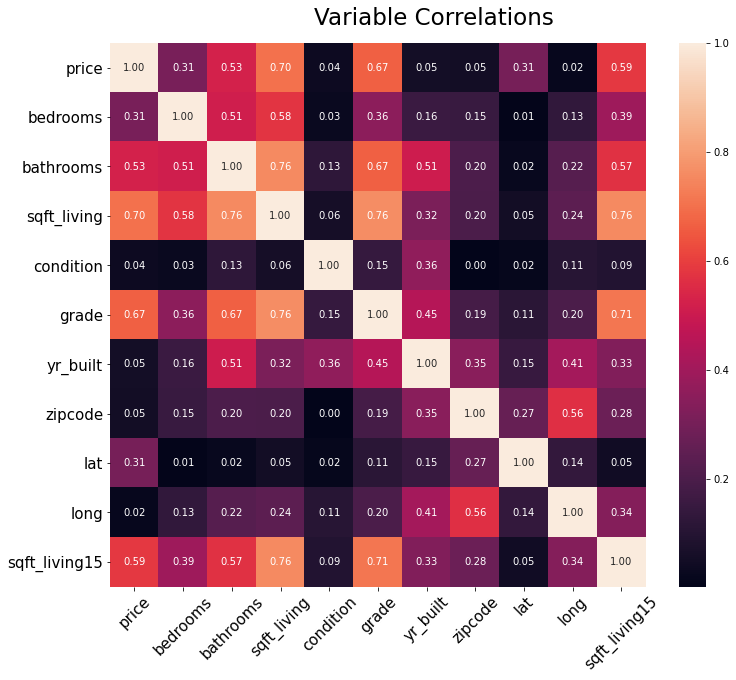

In [3]:
corr = houses_df.corr().abs()
fig, ax=plt.subplots(figsize=(12,10))
fig.suptitle('Variable Correlations', fontsize=23, y=.93)
h = sns.heatmap(corr, annot=True, fmt='.2f')
h.set_xticklabels(h.get_xmajorticklabels(), fontsize = 15, rotation=45)
h.set_yticklabels(h.get_ymajorticklabels(), fontsize = 15);

In [4]:
houses_df['log_price'] = np.log(houses_df['price'])
houses_df['log_sqft_living'] = np.log(houses_df['sqft_living'])

In [5]:
def haversine_distance(lat1, lon1, lat2, lon2):
   r = 6371
   phi1 = np.radians(lat1)
   phi2 = np.radians(lat2)
   delta_phi = np.radians(lat2 - lat1)
   delta_lambda = np.radians(lon2 - lon1)
   a = np.sin(delta_phi / 2)**2 + np.cos(phi1) * np.cos(phi2) *   np.sin(delta_lambda / 2)**2
   res = r * (2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a)))
   return np.round(res, 2)

In [6]:
def distance_from_cc(lat, long):
    return haversine_distance(lat, long, 47.606, -122.332)

In [7]:
houses_df['distance_from_seattle'] = distance_from_cc(houses_df['lat'], houses_df['long'])
houses_df['sqft_divide_distance'] = houses_df['sqft_living'] / houses_df['distance_from_seattle']
# houses_df['rooms'] = houses_df['bedrooms'] + houses_df['bathrooms']
# houses_df['rooms_times_distance'] = houses_df['distance_from_seattle'] * houses_df['rooms']


In [8]:
new_houses_df = houses_df[['price', 'sqft_living', 'grade', 'sqft_living15', 
                           'distance_from_seattle', 'sqft_divide_distance']]

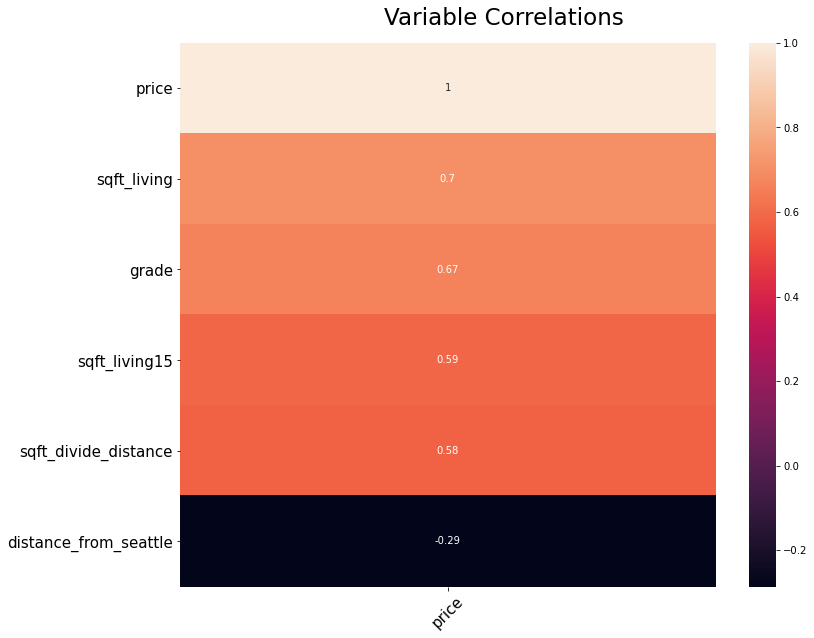

In [9]:
fig, ax=plt.subplots(figsize=(12,10))
fig.suptitle('Variable Correlations', fontsize=23, y=.93)
h = sns.heatmap(new_houses_df.corr()[['price']].sort_values(by='price', ascending=False), annot=True)
h.set_xticklabels(h.get_xmajorticklabels(), fontsize = 15, rotation=45)
h.set_yticklabels(h.get_ymajorticklabels(), fontsize = 15);

In [10]:
y = houses_df.log_price
X = houses_df.drop(labels=['log_price'], axis=1)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state = 5)

In [12]:
houses_model_df = pd.concat([pd.DataFrame(y_train), X_train], axis=1).reset_index(drop=True)
houses_model_df.head()

,log_price,date,price,bedrooms,bathrooms,sqft_living,condition,grade,yr_built,zipcode,lat,long,sqft_living15,log_sqft_living,distance_from_seattle,sqft_divide_distance
0,12.911642,4/3/2015,405000.0,4,2.50,2620,3,9,1987,98058,47.4380,-122.152,2580,7.870930,23.06,113.616652
1,13.356249,8/18/2014,631750.0,3,1.75,2360,5,7,1940,98117,47.6902,-122.382,1660,7.766417,10.08,234.126984
2,13.022543,10/9/2014,452500.0,3,2.50,2240,3,7,2002,98065,47.5361,-121.880,2480,7.714231,34.79,64.386318
3,15.356670,6/17/2014,4670000.0,5,6.75,9640,3,12,1983,98040,47.5570,-122.210,3270,9.173676,10.65,905.164319
4,13.471611,2/24/2015,709000.0,3,2.75,2780,4,8,1913,98118,47.5632,-122.270,1700,7.930206,6.65,418.045113


In [13]:
baseline_model = sm.formula.ols(formula='log_price ~ log_sqft_living', data = houses_model_df).fit()

baseline_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.452
Model:                            OLS   Adj. R-squared:                  0.452
Method:                 Least Squares   F-statistic:                 1.426e+04
Date:                Fri, 27 Aug 2021   Prob (F-statistic):               0.00
Time:                        11:31:17   Log-Likelihood:                -8207.8
No. Observations:               17277   AIC:                         1.642e+04
Df Residuals:                   17275   BIC:                         1.644e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           6.7488      0.053    127.736      0.000       6.645       6.852
log_sqft_living     0.8344      0.007    119.422      0.000       0.821       0.848
==============================================================================
Omnibus:                       99.045   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               92.260
Skew:                           0.146   Prob(JB):                     9.25e-21
Kurtosis:                       2.793   Cond. No.                         137.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

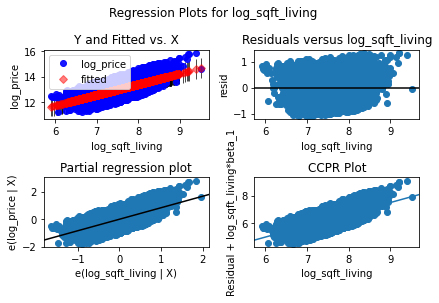

In [14]:
fig = sm.graphics.plot_regress_exog(baseline_model, "log_sqft_living")
fig.tight_layout(pad=1.0)

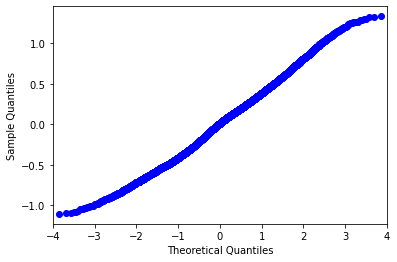

In [15]:
res = baseline_model.resid # residuals
fig = sm.qqplot(res)
plt.show()

In [16]:
y_train_preds = baseline_model.predict(X_train)
y_test_preds = baseline_model.predict(X_test)
baseline_train_mse = mse(y_train_preds, y_train)
baseline_test_mse = mse(y_test_preds, y_test)

print('Baseline mse on training data: ', baseline_train_mse)
print('Baseline mse on testing data:  ', baseline_test_mse)

Baseline mse on training data:  0.1514145280654338
Baseline mse on testing data:   0.14936244222233772


In [18]:
f = 'log_price ~ log_sqft_living + grade + sqft_living15 + distance_from_seattle'

f1 = sm.formula.ols(formula=f, data=houses_model_df).fit()

f1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.716
Model:                            OLS   Adj. R-squared:                  0.716
Method:                 Least Squares   F-statistic:                 1.090e+04
Date:                Fri, 27 Aug 2021   Prob (F-statistic):               0.00
Time:                        11:31:27   Log-Likelihood:                -2525.8
No. Observations:               17277   AIC:                             5062.
Df Residuals:                   17272   BIC:                             5100.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 8.9451      0.051    175.299      0.000       8.845       9.045
log_sqft_living           0.4108      0.008     48.851      0.000       0.394       0.427
grade                     0.1378      0.003     46.550      0.000       0.132       0.144
sqft_living15             0.0002   5.01e-06     32.901      0.000       0.000       0.000
distance_from_seattle    -0.0206      0.000   -100.766      0.000      -0.021      -0.020
==============================================================================
Omnibus:                      212.350   Durbin-Watson:                   1.992
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              362.915
Skew:                           0.072   Prob(JB):                     1.56e-79
Kurtosis:                       3.695   Cond. No.                     5.10e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.1e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [19]:
y_train_preds = f1.predict(X_train)
y_test_preds = f1.predict(X_test)
baseline_train_mse = mse(y_train_preds, y_train)
baseline_test_mse = mse(y_test_preds, y_test)

print('Baseline mse on training data: ', baseline_train_mse)
print('Baseline mse on testing data:  ', baseline_test_mse)

Baseline mse on training data:  0.07843429262880229
Baseline mse on testing data:   0.07715026083968378


In [20]:
f = 'log_price ~ log_sqft_living + sqft_divide_distance + grade + sqft_living15 + distance_from_seattle'

final_model = sm.formula.ols(formula=f, data=houses_model_df).fit()

final_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.723
Model:                            OLS   Adj. R-squared:                  0.723
Method:                 Least Squares   F-statistic:                     9014.
Date:                Fri, 27 Aug 2021   Prob (F-statistic):               0.00
Time:                        11:31:32   Log-Likelihood:                -2318.9
No. Observations:               17277   AIC:                             4650.
Df Residuals:                   17271   BIC:                             4696.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 9.3101      0.053    174.070      0.000       9.205       9.415
log_sqft_living           0.3478      0.009     39.254      0.000       0.330       0.365
sqft_divide_distance      0.0004   1.81e-05     20.460      0.000       0.000       0.000
grade                     0.1328      0.003     45.249      0.000       0.127       0.139
sqft_living15             0.0002   4.98e-06     35.267      0.000       0.000       0.000
distance_from_seattle    -0.0171      0.000    -64.410      0.000      -0.018      -0.017
==============================================================================
Omnibus:                      183.545   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              314.889
Skew:                           0.020   Prob(JB):                     4.20e-69
Kurtosis:                       3.660   Cond. No.                     5.42e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.42e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

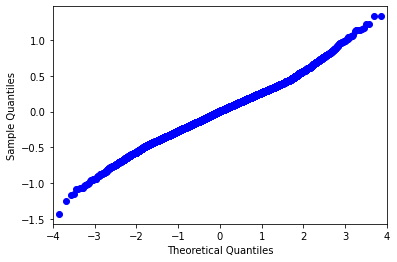

In [21]:
res = final_model.resid # residuals
fig = sm.qqplot(res)
plt.show()

In [22]:
y_train_preds = final_model.predict(X_train)
y_test_preds = final_model.predict(X_test)
baseline_train_mse = mse(y_train_preds, y_train)
baseline_test_mse = mse(y_test_preds, y_test)

print('Baseline mse on training data: ', baseline_train_mse)
print('Baseline mse on testing data:  ', baseline_test_mse)

Baseline mse on training data:  0.0765781972426975
Baseline mse on testing data:   0.07597046311165953
